In [1]:
"""
This file contains the code to run experiments with artificial soft labels.

The experiment is:
    * Train a soft label predictor model on CIFAR-10H
    * Generate artificial soft labels for CIFAR-10
    * Train a model on CIFAR-10 with the artificial soft labels + CIFAR-10H
    * Evaluate the model on CIFAR-10
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
from torchvision import datasets, transforms, models
from typing import Dict, List, Optional, Tuple
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

from generate_soft_labels import create_soft_label_dataset
from soft_label_predictor import ImageHardToSoftLabelModel

In [2]:
def get_device() -> torch.device:
    """Get the appropriate device (CUDA, MPS, or CPU)."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

In [3]:
def load_cifar10_experiment() -> Tuple[Dataset, Dataset, Dataset, Dataset]:
    """Load and split CIFAR-10 dataset into augment, train, test and validation sets."""
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

    full_dataset = datasets.CIFAR10(root="../data/cifar-10", train=True, download=True, transform=transform)
    # Use test dataset for training, similar to CIFAR-10H experiment
    train_dataset = datasets.CIFAR10(root="../data/cifar-10", train=False, download=True, transform=transform)

    # Split full dataset for augmenting, testing, and validation
    augment_size = int(0.7 * len(full_dataset))
    val_size = (len(full_dataset) - augment_size) // 2
    test_size = len(full_dataset) - augment_size - val_size

    generator = torch.Generator().manual_seed(229)
    augment_dataset, test_dataset, val_dataset = torch.utils.data.random_split(
        full_dataset, [augment_size, test_size, val_size], generator=generator
    )

    return augment_dataset, train_dataset, test_dataset, val_dataset

In [4]:
class CIFAR10LabelDataset(Dataset):
    """Dataset wrapper that handles both hard and soft labels consistently."""
    def __init__(self, dataset: Dataset, soft_labels: Optional[np.ndarray] = None):
        self.dataset = dataset
        self.soft_labels = soft_labels

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image, label = self.dataset[idx]
        if self.soft_labels is None:
            # Convert hard labels to one-hot
            label = F.one_hot(torch.tensor(label), num_classes=10).float()
        else:
            label = torch.tensor(self.soft_labels[idx])
        return image, label

# Training
Training is done on the CIFAR-10H dataset. Evaluation is done on the CIFAR-10 train set, which we use as a test set.

In [5]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    num_epochs: int = 20,
    model_path: Optional[str] = None,
) -> Tuple[nn.Module, Dict[str, List[float]]]:
    """Train a neural network model and save the best version based on validation accuracy."""
    # Adjust the final layer for CIFAR-10
    if isinstance(model, models.ResNet):
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 10)
    elif isinstance(model, models.VGG):
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, 10)
        
    print(f"Training on {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    best_val_acc = 0.0

    print(f"\nTraining {model.__class__.__name__}...")
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            # Handle soft labels for training accuracy
            train_labels = labels
            if len(labels.shape) > 1:
                _, train_labels = torch.max(labels, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += train_labels.size(0)
            correct_train += (predicted == train_labels).sum().item()
            
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)

                if len(labels.shape) > 1:  # For soft labels
                    _, predicted = torch.max(outputs.data, 1)
                    _, labels = torch.max(labels, 1)
                else:  # For hard labels
                    _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        accuracy = 100 * correct / total
        val_loss = val_loss / len(val_loader)

        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(accuracy)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Train Acc: {train_acc:.2f}%, "
            f"Val Acc: {accuracy:.2f}%"
        )

        # Save model if validation accuracy improves
        if model_path is not None and accuracy > best_val_acc:
            best_val_acc = accuracy
            torch.save(model.state_dict(), model_path)
            print(f"Saved model with improved validation accuracy: {accuracy:.2f}%")

    return model, history

In [6]:
def evaluate_model(model: nn.Module, dataloader: DataLoader, device: torch.device) -> Dict:
    """Evaluate model performance with multiple metrics."""
    model.eval()
    criterion = nn.CrossEntropyLoss(reduction='sum')
    
    total = correct = total_loss = total_cross_entropy = total_kl_div = 0
    all_preds, all_labels = [], []
    all_pred_probs, all_true_probs = [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            original_labels = labels.clone()
            
            if len(labels.shape) > 1:
                _, labels = torch.max(labels, 1)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            pred_probs = F.softmax(outputs, dim=1)
            log_probs = F.log_softmax(outputs, dim=1)
            
            # Handle soft vs hard labels
            if len(original_labels.shape) > 1:
                original_labels = original_labels.to(device)
                cross_entropy = -(original_labels * log_probs).sum()
                total_cross_entropy += cross_entropy.item()
                kl_div = F.kl_div(log_probs, original_labels, reduction='sum')
                all_true_probs.extend(original_labels.cpu().numpy())
            else:
                total_cross_entropy += loss.item()
                true_probs = F.one_hot(labels, num_classes=outputs.size(1)).float()
                kl_div = F.kl_div(log_probs, true_probs, reduction='sum')
                all_true_probs.extend(true_probs.cpu().numpy())
            
            total_kl_div += kl_div.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_pred_probs.extend(pred_probs.cpu().numpy())

    # Calculate metrics
    metrics = {
        'accuracy': correct / total,
        'precision': precision_score(all_labels, all_preds, average='macro', zero_division=0),
        'recall': recall_score(all_labels, all_preds, average='macro', zero_division=0),
        'f1': f1_score(all_labels, all_preds, average='macro', zero_division=0),
        'loss': total_loss / total,  # Per-sample loss
        'cross_entropy': total_cross_entropy / total,  # Per-sample cross entropy
        'kl_divergence': total_kl_div / total,  # Per-sample KL divergence
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'true_labels': np.array(all_labels),
        'predictions': np.array(all_preds),
        'pred_probabilities': np.array(all_pred_probs),
        'true_probabilities': np.array(all_true_probs)
    }
    
    return metrics

In [7]:
def run_proportion_experiment(
    full_dataset: Dataset,
    soft_label_model: nn.Module,
    val_loader: DataLoader,
    test_loader: DataLoader,
    device: torch.device,
    soft_proportions: List[float] = [0.0, 0.25, 0.5, 0.75, 1.0],
    num_epochs: int = 20,
) -> Tuple[Dict, Dict]:
    """Run experiments with different proportions of soft vs hard labels."""    
    results = {}
    histories = {}  # Store training histories

    total_samples = len(full_dataset)
    
    for prop in soft_proportions:
        print(f"\nRunning experiment with {int(prop*100)}% soft labels")
        model_path = f"models/ResNet_cifar10h_soft_{int(prop*100)}percent.pth"
        
        # Split dataset into soft and hard label portions
        indices = torch.randperm(total_samples, generator=torch.Generator().manual_seed(42))
        soft_size = int(total_samples * prop)
        
        soft_indices = indices[:soft_size]
        hard_indices = indices[soft_size:]
        
        # Create datasets
        if soft_size > 0:
            soft_subset = Subset(full_dataset, soft_indices)
            soft_loader = DataLoader(soft_subset, batch_size=128, shuffle=False)
            soft_dataset = create_soft_label_dataset(soft_label_model, soft_loader, device)
        
        if len(hard_indices) > 0:
            hard_subset = Subset(full_dataset, hard_indices)
            hard_dataset = CIFAR10LabelDataset(hard_subset)
        
        # Combine datasets based on proportion
        combined_dataset = (
            hard_dataset if prop == 0.0
            else soft_dataset if prop == 1.0
            else ConcatDataset([hard_dataset, soft_dataset])
        )
        
        train_loader = DataLoader(combined_dataset, batch_size=128, shuffle=True)
        
        # Train and evaluate model
        model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        model, history = train_model(
            model, train_loader, val_loader, num_epochs=num_epochs, model_path=model_path, device=device
        )
        histories[prop] = history
        
        model.load_state_dict(torch.load(model_path, weights_only=True))
        model = model.to(device)
        model.eval()
        
        # Collect metrics
        results[prop] = {
            **{f'train_{k}': v for k, v in evaluate_model(model, train_loader, device).items()},
            **{f'val_{k}': v for k, v in evaluate_model(model, val_loader, device).items()},
            **{f'test_{k}': v for k, v in evaluate_model(model, test_loader, device).items()}
        }
    
    return results, histories

In [8]:
def plot_basic_metrics(results: Dict):
    """Plot basic metrics like accuracy, loss etc."""
    metrics = [
        ('cross_entropy', 'Cross Entropy Loss'),
        ('kl_divergence', 'KL Divergence'),
        ('accuracy', 'Accuracy'),
        ('precision', 'Precision'),
        ('recall', 'Recall'),
        ('f1', 'F1 Score')
    ]

    proportions = list(results.keys())
    x_axis = [p*100 for p in proportions]

    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    axes = axes.flatten()

    for i, (metric, title) in enumerate(metrics):
        train_metric = [results[p][f'train_{metric}'] * 100 for p in proportions]
        val_metric = [results[p][f'val_{metric}'] * 100 for p in proportions]
        test_metric = [results[p][f'test_{metric}'] * 100 for p in proportions]
        
        axes[i].plot(x_axis, train_metric, 'b-o', label='Training')
        axes[i].plot(x_axis, val_metric, 'r-o', label='Validation')
        axes[i].plot(x_axis, test_metric, 'g-o', label='Test')
        axes[i].set_xlabel('Percentage of Soft Labels')
        axes[i].set_ylabel(f'{title} (%)')
        axes[i].set_title(f'{title} vs Proportion of Soft Labels')
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.savefig('results/metrics.png')
    plt.show()

def plot_confusion_matrices(results: Dict):
    """Plot confusion matrices for different proportions of soft labels."""
    proportions = list(results.keys())
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()

    for i, prop in enumerate(proportions):
        cm = results[prop]['test_confusion_matrix']  # Use test set confusion matrix
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', ax=axes[i], cmap='Blues')
        axes[i].set_title(f'Normalized Confusion Matrix ({int(prop*100)}% Soft Labels)')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.savefig('results/confusion_matrices.png')
    plt.show()

def plot_roc_pr_curves(results: Dict):
    """Plot ROC and Precision-Recall curves."""
    proportions = list(results.keys())
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    for prop in proportions:
        test_true = results[prop]['test_true_labels']
        test_probs = results[prop]['test_pred_probabilities']
        
        # One-vs-Rest ROC curves
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        # Convert to one-hot format
        test_true_bin = np.eye(10)[test_true]
        
        for class_idx in range(10):
            fpr[class_idx], tpr[class_idx], _ = roc_curve(
                test_true_bin[:, class_idx], test_probs[:, class_idx])
            roc_auc[class_idx] = auc(fpr[class_idx], tpr[class_idx])
        
        # Compute micro-average ROC curve and ROC area
        fpr_micro, tpr_micro, _ = roc_curve(test_true_bin.ravel(), test_probs.ravel())
        roc_auc_micro = auc(fpr_micro, tpr_micro)
        
        ax1.plot(fpr_micro, tpr_micro, 
                label=f'{int(prop*100)}% Soft Labels (AUC = {roc_auc_micro:.2f})')
        
        # PR curve
        precision = dict()
        recall = dict()
        pr_auc = dict()
        
        for class_idx in range(10):
            precision[class_idx], recall[class_idx], _ = precision_recall_curve(
                test_true_bin[:, class_idx], test_probs[:, class_idx])
            pr_auc[class_idx] = auc(recall[class_idx], precision[class_idx])
        
        # Compute micro-average PR curve
        precision_micro, recall_micro, _ = precision_recall_curve(
            test_true_bin.ravel(), test_probs.ravel())
        pr_auc_micro = auc(recall_micro, precision_micro)
        
        ax2.plot(recall_micro, precision_micro,
                label=f'{int(prop*100)}% Soft Labels (AUC = {pr_auc_micro:.2f})')

    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves (Micro-averaged)')
    ax1.legend()
    ax1.grid(True)

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves (Micro-averaged)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('results/roc_pr_curves.png')
    plt.show()
    
def plot_training_curves(histories: Dict[float, Dict[str, List[float]]]):
    """Plot training curves for different soft label proportions."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    for prop, history in histories.items():
        label = f"{int(prop*100)}% Soft Labels"
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Loss curves
        ax1.plot(epochs, history['train_loss'], '--', label=f'Train ({label})')
        ax1.plot(epochs, history['val_loss'], '-', label=f'Val ({label})')
        
        # Accuracy curves
        ax2.plot(epochs, history['train_acc'], '--', label=f'Train ({label})')
        ax2.plot(epochs, history['val_acc'], '-', label=f'Val ({label})')
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('results/training_curves.png')
    plt.show()

In [9]:
# Load datasets
cifar10_datasets = load_cifar10_experiment()
cifar10_hard_augment_dataset, _, cifar10_hard_test_dataset, cifar10_hard_val_dataset = cifar10_datasets

# Create data loaders
cifar10_hard_test_loader = DataLoader(cifar10_hard_test_dataset, batch_size=128, shuffle=False)
cifar10_hard_val_loader = DataLoader(cifar10_hard_val_dataset, batch_size=128, shuffle=False)

print(
    f"CIFAR-10 dataset loaded with "
    f"{len(cifar10_hard_augment_dataset)} augment, "
    f"{len(cifar10_hard_test_dataset)} test, and "
    f"{len(cifar10_hard_val_dataset)} validation samples"
)

Files already downloaded and verified
Files already downloaded and verified
CIFAR-10 dataset loaded with 35000 augment, 7500 test, and 7500 validation samples


In [10]:
# Load and prepare soft label model
device = get_device()
soft_label_model = ImageHardToSoftLabelModel().to(device)
soft_label_model.load_state_dict(torch.load("models/soft_label_model.pt", weights_only=True))
soft_label_model.eval()

ImageHardToSoftLabelModel(
  (image_encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (4): Sequential(
      (0): ResidualBlock(
    

In [11]:
# Run experiments
results, histories = run_proportion_experiment(
    full_dataset=cifar10_hard_augment_dataset,
    soft_label_model=soft_label_model,
    val_loader=cifar10_hard_val_loader,
    test_loader=cifar10_hard_test_loader,
    soft_proportions=[0.0, 0.25, 0.5, 0.75, 1.0],
    num_epochs=50,
    device=device
)


Running experiment with 0% soft labels
Training on cuda

Training ResNet...
Epoch [1/50] Train Loss: 1.0996, Val Loss: 0.9575, Train Acc: 61.74%, Val Acc: 66.84%
Saved model with improved validation accuracy: 66.84%
Epoch [2/50] Train Loss: 0.7748, Val Loss: 1.0467, Train Acc: 73.27%, Val Acc: 65.39%
Epoch [3/50] Train Loss: 0.6769, Val Loss: 0.9004, Train Acc: 76.75%, Val Acc: 69.00%
Saved model with improved validation accuracy: 69.00%
Epoch [4/50] Train Loss: 0.6070, Val Loss: 0.6522, Train Acc: 79.24%, Val Acc: 78.03%
Saved model with improved validation accuracy: 78.03%
Epoch [5/50] Train Loss: 0.5656, Val Loss: 0.6213, Train Acc: 80.77%, Val Acc: 78.67%
Saved model with improved validation accuracy: 78.67%
Epoch [6/50] Train Loss: 0.5235, Val Loss: 0.7855, Train Acc: 82.25%, Val Acc: 74.51%
Epoch [7/50] Train Loss: 0.5061, Val Loss: 0.6304, Train Acc: 82.44%, Val Acc: 78.13%
Epoch [8/50] Train Loss: 0.4650, Val Loss: 0.7244, Train Acc: 84.03%, Val Acc: 76.64%
Epoch [9/50] Train 

In [12]:
# Display results
df = pd.DataFrame(results).T * 100
df.index = [f"{idx:.0f}%" for idx in df.index * 100]
print("\nResults by Soft Label Percentage:")
print("================================")
df[['train_accuracy', 'val_accuracy', 'test_accuracy', 'train_loss', 'val_loss', 'train_cross_entropy', 'val_cross_entropy', 'train_kl_divergence', 'val_kl_divergence']]


Results by Soft Label Percentage:


,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,train_cross_entropy,val_cross_entropy,train_kl_divergence,val_kl_divergence
0%,94.397143,83.973333,83.866667,16.012394,54.645053,16.012394,54.645053,16.012394,54.645053
25%,96.557143,83.04,83.48,10.264157,61.596966,12.832345,61.596966,10.63651,61.596967
50%,97.302857,82.413333,82.24,8.861681,64.158687,13.343141,64.158687,8.999012,64.158687
75%,98.1,80.053333,80.173333,6.824596,71.671622,13.01364,71.671622,6.489342,71.671622
100%,99.88,77.346667,77.16,1.920928,92.539318,9.886167,92.539318,1.136445,92.53932


In [13]:
print(histories)

{0.0: {'train_loss': [1.0996028952790002, 0.7747870259476404, 0.6768672502171384, 0.6069531330879587, 0.5655863229593221, 0.5234574404728674, 0.5061435009876307, 0.46503832098776404, 0.44856605281795026, 0.4528728920395357, 0.4121117123069554, 0.3915052286682338, 0.37296823879880625, 0.37540998048808455, 0.3684617308151983, 0.5681883290301274, 0.46137714853687006, 0.3476778542364601, 0.31989017449808815, 0.299003958267017, 0.2907587208778319, 0.5059039792875304, 0.5943979612232124, 0.366391107929449, 0.3151273046531817, 0.5032376027020224, 0.3477989629346089, 0.2886311802333289, 0.25664397465051525, 0.2408807981405815, 0.2301153991996807, 0.22824724932221602, 0.22142148371378, 0.21481805011956362, 0.20163059476627052, 0.20586255342312101, 0.19759678862390728, 0.19887174644174366, 0.18846681798352813, 0.3940793623481571, 0.30838239013496105, 0.21643625721879248, 0.18996799552310123, 0.17598644926817747, 0.1664925157262461, 0.16072628214737794, 0.15858807588798285, 0.15106231860653327, 0

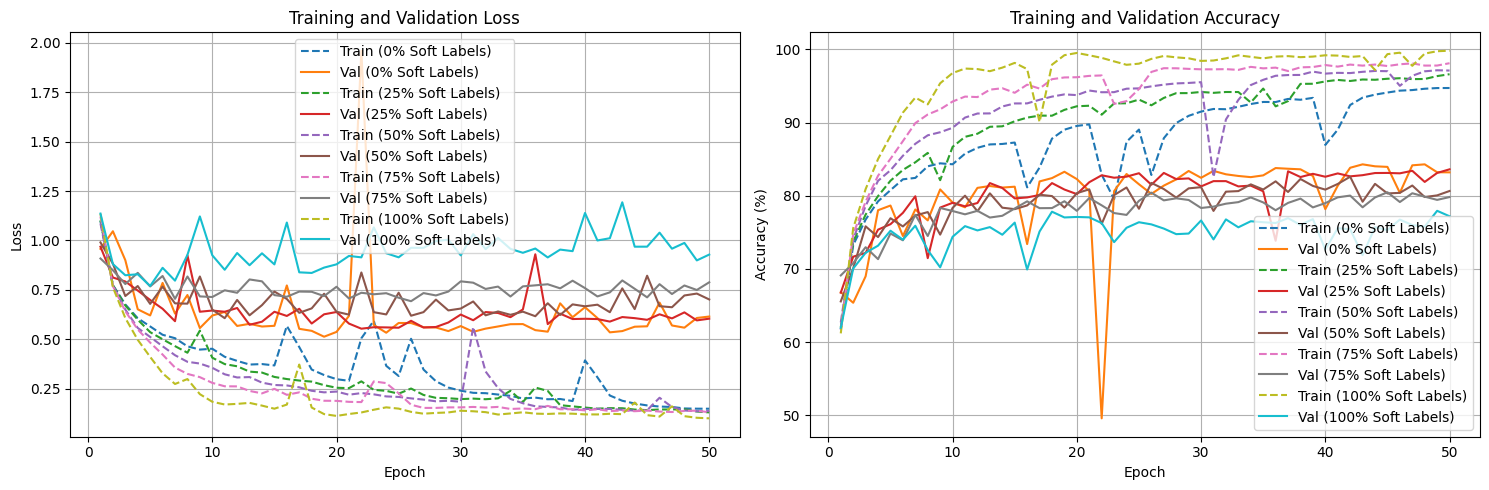

In [14]:
plot_training_curves(histories)

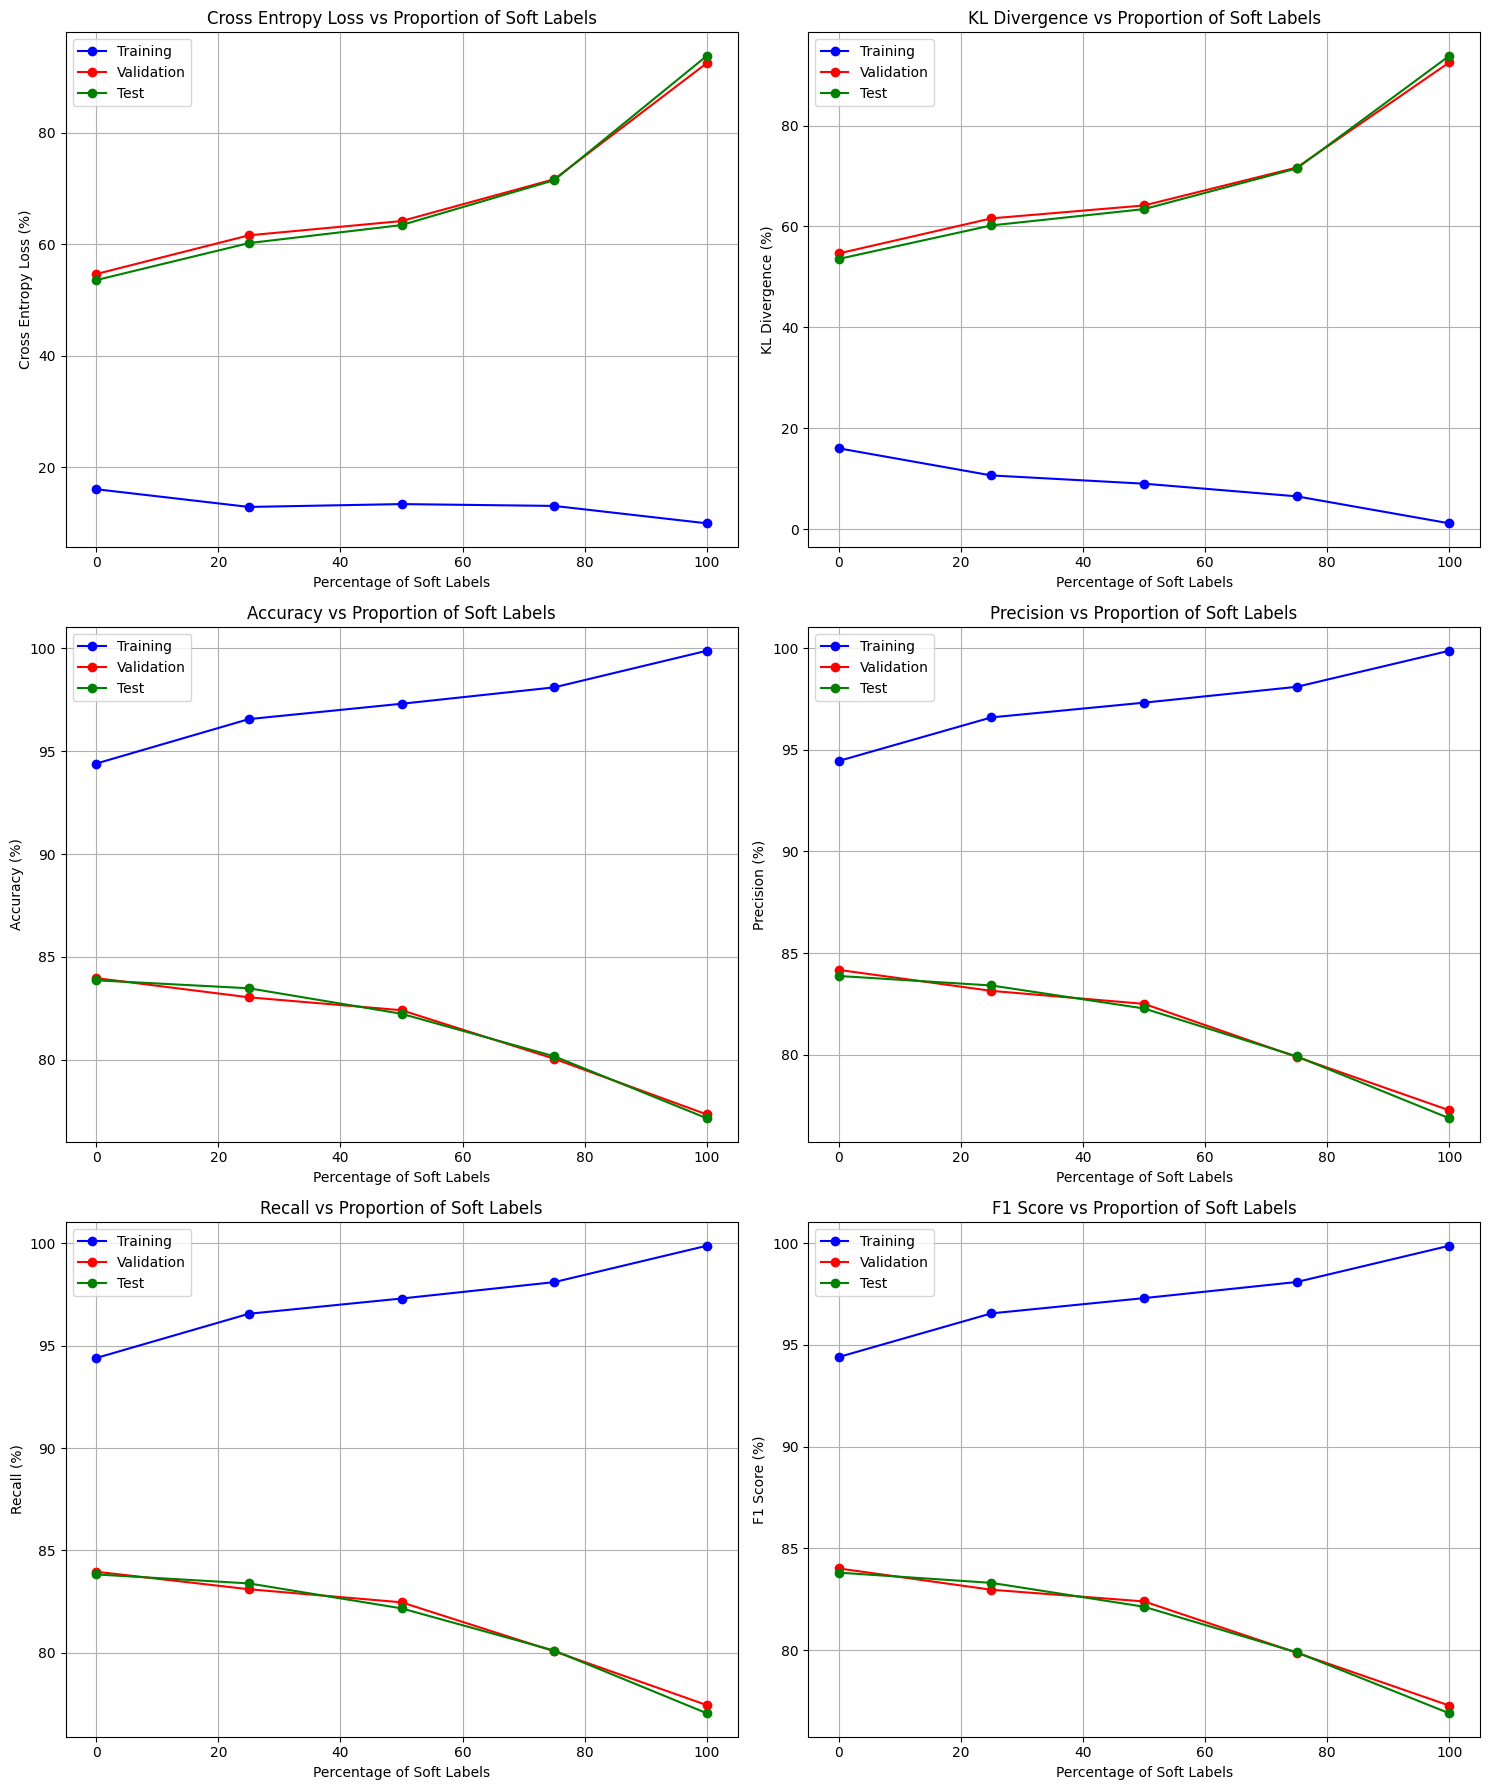

In [15]:
plot_basic_metrics(results)

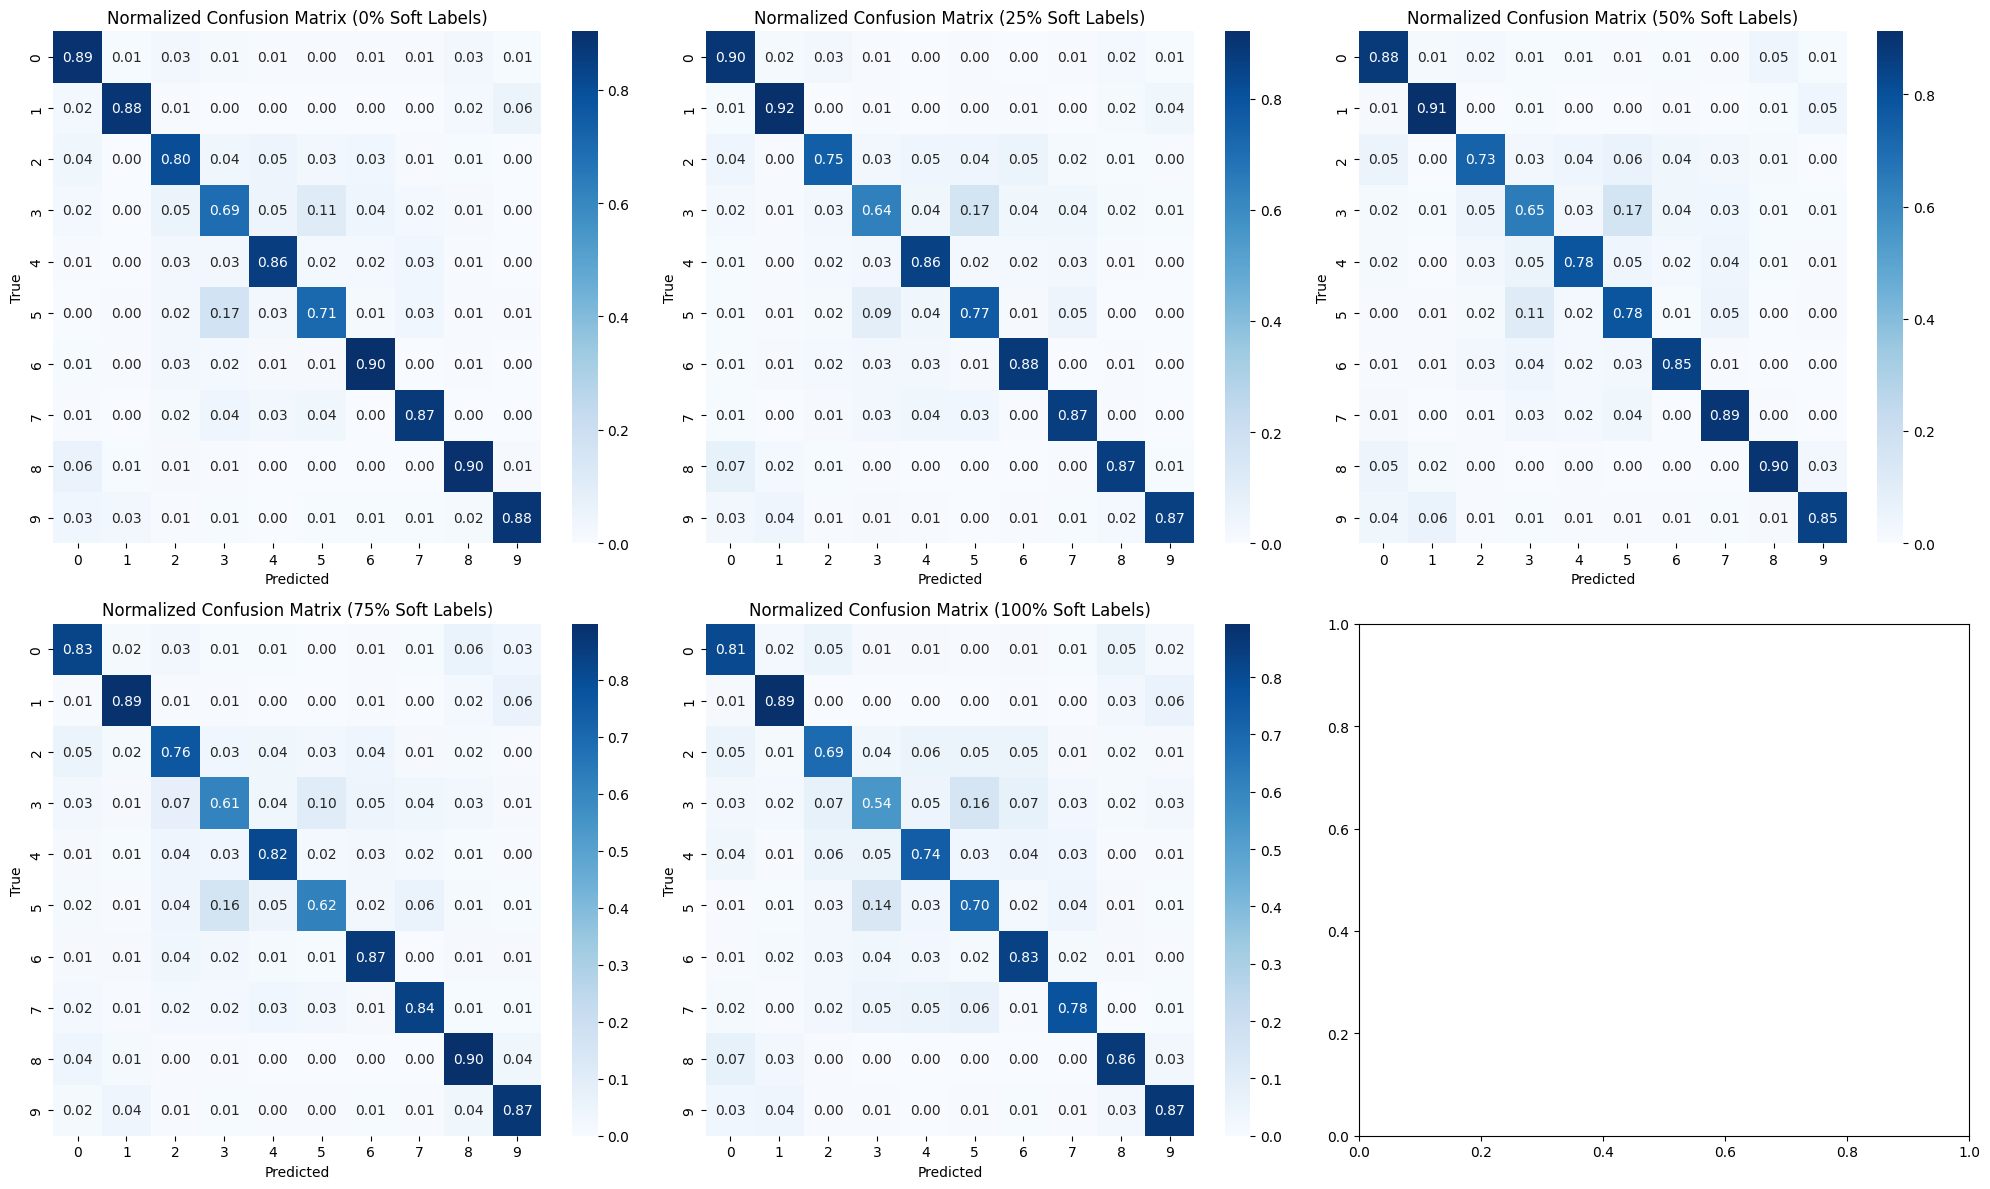

In [16]:
plot_confusion_matrices(results)

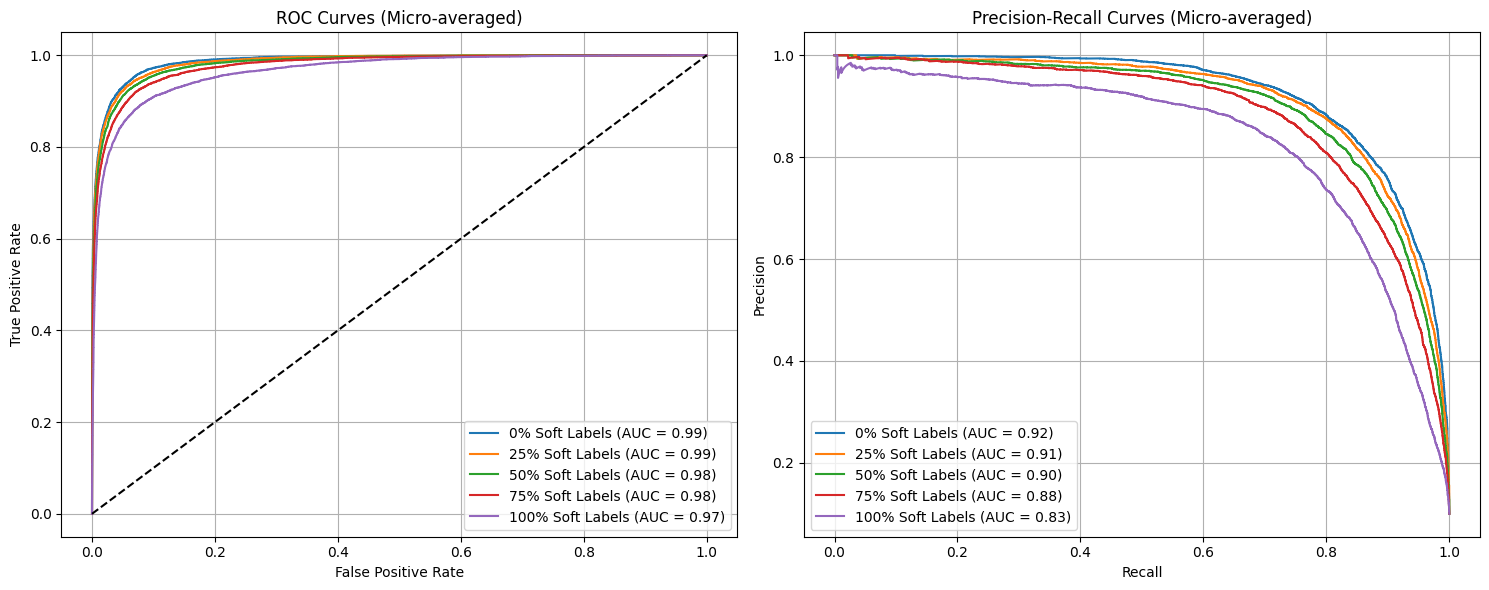

In [17]:
plot_roc_pr_curves(results)